# Importing and Data Preparation

In [185]:
# !pip install h2o
# #we need to run this at every instance if we are using google colab, 

In [186]:
import h2o
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator

In [187]:
# importing relevant libraries

import time

import matplotlib.pyplot as plt # plotting graphs
import seaborn as sns

from pylab import rcParams

import sys
import shap

import numpy as np # linear algebra
np.set_printoptions(threshold=sys.maxsize) # view max elements of numpy array

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# pd.set_option('display.max_columns', None) #pandas shows maximum columns
# pd.set_option('display.max_rows', 146) #pandas shows 146 rows

import os # for file directories

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, make_scorer, mean_squared_error, accuracy_score)
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import model_selection

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA

In [188]:
# ls # shows our directory

In [189]:
# os.chdir('/content/drive/MyDrive/Colab Files/MercJbs') # change directory

In [190]:
# ls # show current files/folders in directory

In [191]:
# pwd

In [192]:
# import dataset
df_day = pd.read_csv(r'data/day_approach_maskedID_timeseries_v2.0.csv')

In [193]:
df_day.head(1)

,Unnamed: 0,nr_sessions,total_km,km_z3-4,km_z5-t1-t2,km_sprinting,strength_training,hours_alternative,perceived_exertion,perceived_trainingsuccess,...,km_z5-t1-t2_6,km_sprinting_6,strength_training_6,hours_alternative_6,perceived_exertion_6,perceived_trainingsuccess_6,perceived_recovery_6,athlete_id,injury,date
0,0,1,5.8,0.0,0.6,1.2,0,0.0,0.11,0.0,...,0.0,0.0,0,1.0,0.1,0.0,0.15,0,0,0


In [194]:
df_day.drop(['Unnamed: 0'], axis = 1, inplace = True)
df_day['date'] = df_day['date'].astype('category')

In [195]:
# df_day['injury'] = df_day['injury'].apply(lambda x: 'yes' if x == 1 else 'no')

In [196]:

df_day[df_day.nunique()[df_day.nunique() < 30].index] = df_day[df_day.nunique()[df_day.nunique() < 30].index].astype('category')
df_day['injury'].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [197]:
df_day.head()

,nr_sessions,total_km,km_z3-4,km_z5-t1-t2,km_sprinting,strength_training,hours_alternative,perceived_exertion,perceived_trainingsuccess,perceived_recovery,...,km_z5-t1-t2_6,km_sprinting_6,strength_training_6,hours_alternative_6,perceived_exertion_6,perceived_trainingsuccess_6,perceived_recovery_6,athlete_id,injury,date
0,1,5.8,0.0,0.6,1.2,0,0.00,0.11,0.00,0.18,...,0.0,0.0,0,1.0,0.10,0.00,0.15,0,0,0
1,0,0.0,0.0,0.0,0.0,0,0.00,-0.01,-0.01,-0.01,...,0.5,1.2,0,0.0,0.10,0.00,0.17,0,0,1
2,1,0.0,0.0,0.0,0.0,1,0.00,0.10,0.00,0.17,...,0.0,0.0,0,0.0,-0.01,-0.01,-0.01,0,0,2
3,0,0.0,0.0,0.0,0.0,0,0.00,-0.01,-0.01,-0.01,...,0.0,0.0,1,0.0,0.10,0.00,0.17,0,0,3
4,1,0.0,0.0,0.0,0.0,0,1.08,0.08,0.00,0.18,...,0.0,0.0,0,0.0,0.11,0.00,0.17,0,0,4


In [198]:
df_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42766 entries, 0 to 42765
Data columns (total 73 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   nr_sessions                  42766 non-null  category
 1   total_km                     42766 non-null  float64 
 2   km_z3-4                      42766 non-null  float64 
 3   km_z5-t1-t2                  42766 non-null  float64 
 4   km_sprinting                 42766 non-null  float64 
 5   strength_training            42766 non-null  category
 6   hours_alternative            42766 non-null  float64 
 7   perceived_exertion           42766 non-null  float64 
 8   perceived_trainingsuccess    42766 non-null  float64 
 9   perceived_recovery           42766 non-null  float64 
 10  nr_sessions_1                42766 non-null  category
 11  total_km_1                   42766 non-null  float64 
 12  km_z3-4_1                    42766 non-null  float64 
 13  k

In [199]:
df_day.to_csv('data/day_approach_maskedID_timeseries_v3.0.csv')

# Introduction

In this notebook, we run some advance classification ML algorithms on our datasets. As a result of our dataset having many rows/entries (42766) and columns (73), we use a dimensionality reduction technique (PCA) to see the variability on the data.

<!-- ## PCA -->

<!-- from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA -->

<!-- Xd = df_day.drop(columns = ['injury'])
yd = df_day['injury'] -->

<!-- pca = make_pipeline(StandardScaler(), PCA(.95))
# pca = PCA()
pca.fit_transform(Xd)
pca -->

<!-- **Explained variance** is the amount of variance explained by each of the selected components.  -->

<!-- # pca[1].n_components_ -->

<!-- explained = pca[1].explained_variance_ratio_
explained -->

<!-- cumulative_explained = explained.cumsum()

cumulative_explained -->

<!-- pca[1].components_.shape -->

<!-- plt.figure(figsize=(15,7.5))
plt.plot(range(0, 53), explained, label='Explained Variance')
plt.plot(range(0, 53), cumulative_explained, label='Cumulative Explained Variance')
plt.xlabel('Principal Components')
plt.vlines(x=42, ymin= -0.1, ymax=1.1, colors= 'k', label = "42nd Component")
plt.hlines(y=0.90, xmin=-0.5, xmax=72, colors= 'g', linestyles='--', label = "90% Explained")
plt.title('Explained Variance Ratio')
plt.legend()
plt.show() -->

# Model 1 : Autoencoder
**What is Autoencoder?**

Autoencoder is an unsupervised artificial neural network that learns how to efficiently compress and encode data then learns how to reconstruct the data back from the reduced encoded representation to a representation that is as close to the original input as possible. Autoencoder, by design, reduces data dimensions by learning how to ignore the noise in the data. 

**Why Autoencoder works for Anomaly Detection?**

Autoencoders are great in learning what is normal. I can identify the normal region ina distribution then anything that is considered an outlier will return a high reconstruction error.

Let's start by installing some pre-requisite libraries, h20. 

**H2O** is an open-source library that can be used to do a number of machine learning tasks. It has a function for the autoencoders. Let's have a look

## Starting and initializing H2O server.

In [200]:
h2o.init() # initializing h2o server
# h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,4 hours 52 mins
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.4
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_USER_61dy3j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.544 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


We now load the dataset into a H2O dataframe and splitting the DS.

In [201]:
hdf_day = h2o.import_file(r"data/day_approach_maskedID_timeseries_v3.0.csv") #import the file as a h2o file
hdf_day["date"] = hdf_day["date"].asfactor() # coonvert date to factor i.e categorical
hdf_day["injury"] = hdf_day["injury"].asfactor()
features_day  = hdf_day.drop(['athlete_id', 'C1'], axis=1) # we do not need the athlete id again alonside the 'C1' column which is an automatic addition by h2o import
train_day , test_day = features_day.split_frame([0.8]) # 80% of data for training and 20% for testing 

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


We used a 80-20 split between the training and testing because of the imbalance in the dataset. This spit enables us to get enough of the undersampled class.

In [202]:
features_day.head(3)

nr_sessions,total_km,km_z3-4,km_z5-t1-t2,km_sprinting,strength_training,hours_alternative,perceived_exertion,perceived_trainingsuccess,perceived_recovery,nr_sessions_1,total_km_1,km_z3-4_1,km_z5-t1-t2_1,km_sprinting_1,strength_training_1,hours_alternative_1,perceived_exertion_1,perceived_trainingsuccess_1,perceived_recovery_1,nr_sessions_2,total_km_2,km_z3-4_2,km_z5-t1-t2_2,km_sprinting_2,strength_training_2,hours_alternative_2,perceived_exertion_2,perceived_trainingsuccess_2,perceived_recovery_2,nr_sessions_3,total_km_3,km_z3-4_3,km_z5-t1-t2_3,km_sprinting_3,strength_training_3,hours_alternative_3,perceived_exertion_3,perceived_trainingsuccess_3,perceived_recovery_3,nr_sessions_4,total_km_4,km_z3-4_4,km_z5-t1-t2_4,km_sprinting_4,strength_training_4,hours_alternative_4,perceived_exertion_4,perceived_trainingsuccess_4,perceived_recovery_4,nr_sessions_5,total_km_5,km_z3-4_5,km_z5-t1-t2_5,km_sprinting_5,strength_training_5,hours_alternative_5,perceived_exertion_5,perceived_trainingsuccess_5,perceived_recovery_5,nr_sessions_6,total_km_6,km_z3-4_6,km_z5-t1-t2_6,km_sprinting_6,strength_training_6,hours_alternative_6,perceived_exertion_6,perceived_trainingsuccess_6,perceived_recovery_6,injury,date
1,5.8,0,0.6,1.2,0,0,0.11,0,0.18,0,0,0,0,0,0,0,-0.01,-0.01,-0.01,1,0,0,0,0,1,0,0.1,0,0.17,0,0,0,0,0,0,0,-0.01,-0.01,-0.01,1,0,0,0,0,0,1.08,0.08,0,0.18,1,16.4,10,0,0,1,0,0.11,0,0.17,1,0,0,0,0,0,1,0.1,0,0.15,0,0
0,0,0,0,0,0,0,-0.01,-0.01,-0.01,1,0,0,0,0,1,0,0.1,0,0.17,0,0,0,0,0,0,0,-0.01,-0.01,-0.01,1,0,0,0,0,0,1.08,0.08,0,0.18,1,16.4,10,0,0,1,0,0.11,0,0.17,1,0,0,0,0,0,1,0.1,0,0.15,1,5.2,0,0.5,1.2,0,0,0.1,0,0.17,0,1
1,0,0,0,0,1,0,0.1,0,0.17,0,0,0,0,0,0,0,-0.01,-0.01,-0.01,1,0,0,0,0,0,1.08,0.08,0,0.18,1,16.4,10,0,0,1,0,0.11,0,0.17,1,0,0,0,0,0,1,0.1,0,0.15,1,5.2,0,0.5,1.2,0,0,0.1,0,0.17,0,0,0,0,0,0,0,-0.01,-0.01,-0.01,0,2


In [203]:
features_day.types

{'nr_sessions': 'int',
 'total_km': 'real',
 'km_z3-4': 'real',
 'km_z5-t1-t2': 'real',
 'km_sprinting': 'real',
 'strength_training': 'int',
 'hours_alternative': 'real',
 'perceived_exertion': 'real',
 'perceived_trainingsuccess': 'real',
 'perceived_recovery': 'real',
 'nr_sessions_1': 'int',
 'total_km_1': 'real',
 'km_z3-4_1': 'real',
 'km_z5-t1-t2_1': 'real',
 'km_sprinting_1': 'real',
 'strength_training_1': 'int',
 'hours_alternative_1': 'real',
 'perceived_exertion_1': 'real',
 'perceived_trainingsuccess_1': 'real',
 'perceived_recovery_1': 'real',
 'nr_sessions_2': 'int',
 'total_km_2': 'real',
 'km_z3-4_2': 'real',
 'km_z5-t1-t2_2': 'real',
 'km_sprinting_2': 'real',
 'strength_training_2': 'int',
 'hours_alternative_2': 'real',
 'perceived_exertion_2': 'real',
 'perceived_trainingsuccess_2': 'real',
 'perceived_recovery_2': 'real',
 'nr_sessions_3': 'int',
 'total_km_3': 'real',
 'km_z3-4_3': 'real',
 'km_z5-t1-t2_3': 'real',
 'km_sprinting_3': 'real',
 'strength_training_3

We now preprocess the dataset by seperating training and test data.

In [204]:
# converting to pandas dataframe
train_day_df = train_day.as_data_frame()
test_day_df = test_day.as_data_frame()

# noinjury_df_tr = train_day_df[train_day_df['injury'] == 0]
# injury_df_tr = train_day_df[train_day_df['injury'] == 1]

In [205]:
# drop the Class variable

Y_test_df = test_day_df['injury'] # true labels of the testing set
Y_test_df_ = pd.DataFrame(Y_test_df) # convert to pandas dataframe from pandas series
test_df = test_day_df.drop(['injury'], axis=1)

In [206]:
# converting to h2o frame
Y_test_h2o = h2o.H2OFrame(Y_test_df_) 
train_h2o = h2o.H2OFrame(train_day_df) 
test_h2o = h2o.H2OFrame(test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [207]:
cols = train_h2o.columns
cols.remove('injury')

In [208]:
cols

['nr_sessions',
 'total_km',
 'km_z3-4',
 'km_z5-t1-t2',
 'km_sprinting',
 'strength_training',
 'hours_alternative',
 'perceived_exertion',
 'perceived_trainingsuccess',
 'perceived_recovery',
 'nr_sessions_1',
 'total_km_1',
 'km_z3-4_1',
 'km_z5-t1-t2_1',
 'km_sprinting_1',
 'strength_training_1',
 'hours_alternative_1',
 'perceived_exertion_1',
 'perceived_trainingsuccess_1',
 'perceived_recovery_1',
 'nr_sessions_2',
 'total_km_2',
 'km_z3-4_2',
 'km_z5-t1-t2_2',
 'km_sprinting_2',
 'strength_training_2',
 'hours_alternative_2',
 'perceived_exertion_2',
 'perceived_trainingsuccess_2',
 'perceived_recovery_2',
 'nr_sessions_3',
 'total_km_3',
 'km_z3-4_3',
 'km_z5-t1-t2_3',
 'km_sprinting_3',
 'strength_training_3',
 'hours_alternative_3',
 'perceived_exertion_3',
 'perceived_trainingsuccess_3',
 'perceived_recovery_3',
 'nr_sessions_4',
 'total_km_4',
 'km_z3-4_4',
 'km_z5-t1-t2_4',
 'km_sprinting_4',
 'strength_training_4',
 'hours_alternative_4',
 'perceived_exertion_4',
 'perce

We now create a local estimator and start the training process

In the deep learning model below, we included the h2o library for anomaly detection i.e autoencoder.

In [209]:
# our model with its hyper parameters

deepl_model = H2ODeepLearningEstimator(activation = "Tanh",
                               hidden = [15,7,7,7,15],
                               epochs = 100,
                               standardize = True,
                                stopping_metric = 'MSE',
                                loss = 'automatic',
                                train_samples_per_iteration = 32,
                                shuffle_training_data = True,     
                               autoencoder = True,
                               l1 = 10e-5)

In [210]:
%timeit deepl_model.train(x = cols , y = 'injury', training_frame = train_h2o) # this takes a while at least an hour 

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
3min 38s ± 46.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [211]:
# Evaluate performance:

perf = deepl_model.model_performance()
perf


ModelMetricsAutoEncoder: deeplearning
** Reported on train data. **

MSE: 0.009022512261840393
RMSE: 0.09498690573884588


The MSE & RMSE helps us to understand how far off our prediction is on the training data as opposed to the actual results. The small number above which almost equals zero tells us that our model performs well on the training set.

We also note that $RMSE = \sqrt{MSE}$

Show the model feature importance in a dataframe

In [212]:
deepl_model._model_json['output']['variable_importances'].as_data_frame()

,variable,relative_importance,scaled_importance,percentage
0,nr_sessions,1.000000,1.000000,0.050753
1,nr_sessions_3,0.994011,0.994011,0.050449
2,nr_sessions_1,0.991109,0.991109,0.050302
3,perceived_trainingsuccess,0.879983,0.879983,0.044662
4,perceived_trainingsuccess_3,0.856190,0.856190,0.043454
...,...,...,...,...
67,km_sprinting_5,0.002753,0.002753,0.000140
68,km_sprinting_1,0.002240,0.002240,0.000114
69,km_sprinting_4,0.001850,0.001850,0.000094
70,km_sprinting_6,0.001825,0.001825,0.000093


Visualization of the feature importance

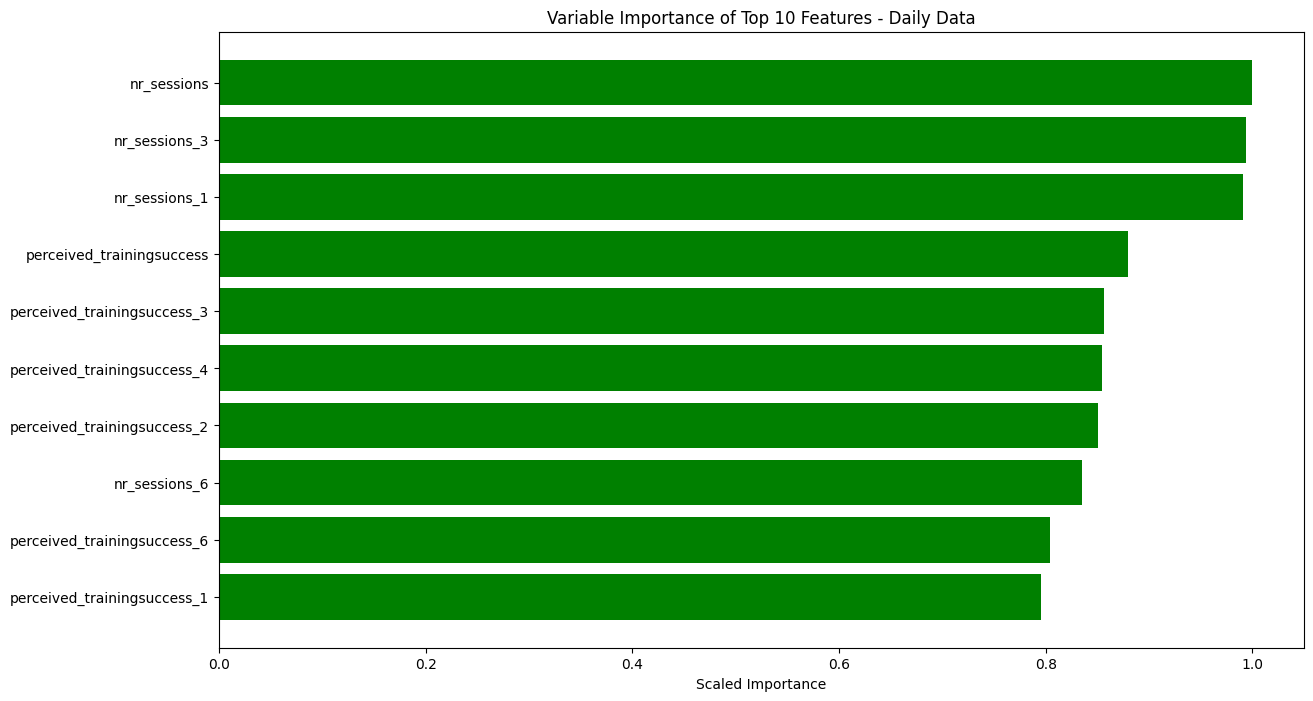

In [213]:
# plotting the variable importance
rcParams['figure.figsize'] = 14, 8
#plt.rcdefaults()
fig, ax = plt.subplots()

variables = deepl_model._model_json['output']['variable_importances']['variable']
var = variables[0:10]
y_pos = np.arange(len(var))

scaled_importance = deepl_model._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance[0:10]

ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
# ax.set_yticklabels(variables)
ax.set_yticklabels(var)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance of Top 10 Features - Daily Data')
plt.savefig('feat_imp_dailydata.png' ,bbox_inches='tight')
plt.show()

Visualize the model loss.

Text(0.5, 0, 'epoch')

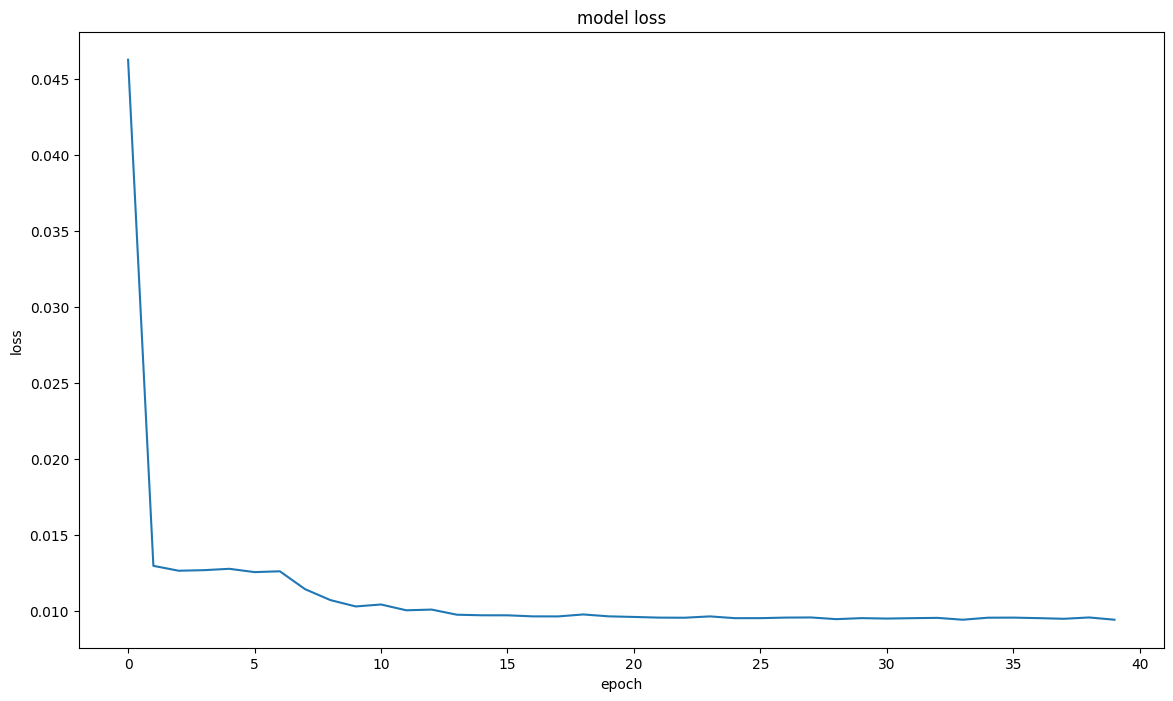

In [30]:
# plotting the loss

scoring_history = deepl_model.score_history()

rcParams['figure.figsize'] = 14, 8
plt.plot(scoring_history['training_mse'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

Visualize the scatter plot across the dataset

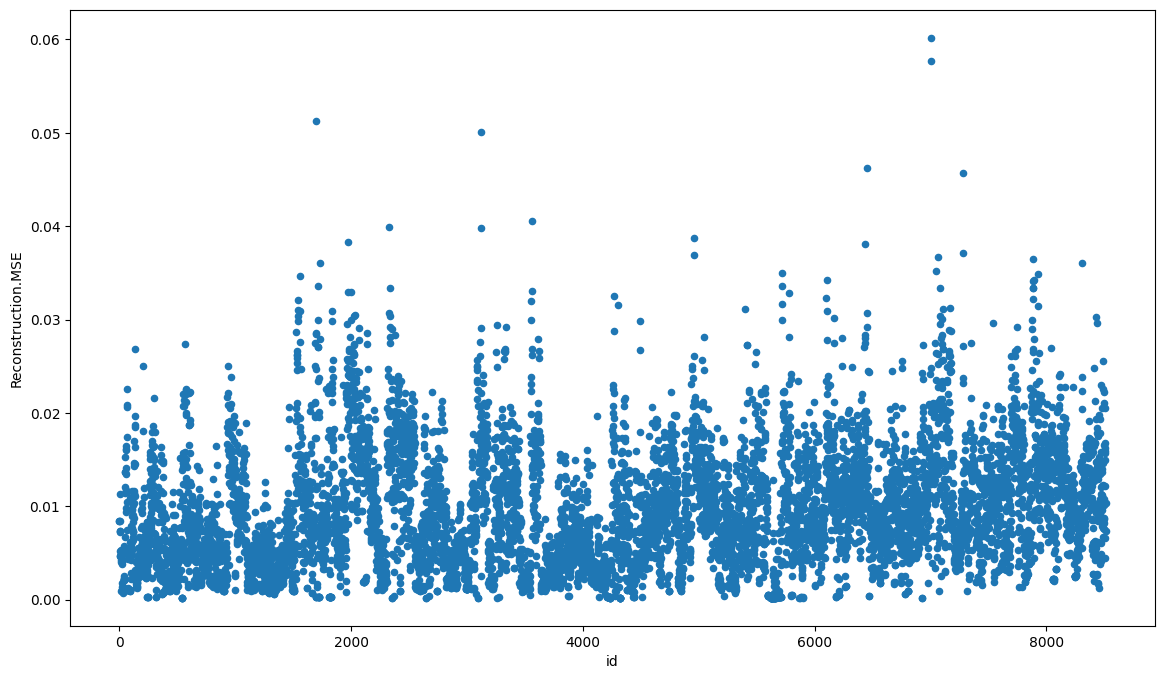

In [31]:
test_rec_error = deepl_model.anomaly(test_h2o) 

# deepl is a H2O function which calculates the error for the dataset

# converting to pandas dataframe
test_rec_error_df = test_rec_error.as_data_frame()

# plotting the testing dataset against the error
test_rec_error_df['id'] = test_rec_error_df.index
rcParams['figure.figsize'] = 14, 8
test_rec_error_df.plot(kind="scatter", x='id', y="Reconstruction.MSE")
plt.show()

In [32]:
# predicting the class for the testing dataset
predictions = deepl_model.predict(test_h2o)
error_df = pd.DataFrame({'reconstruction_error': test_rec_error_df['Reconstruction.MSE'],
                        'true_class': Y_test_df})
error_df.groupby('true_class').count()

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


,reconstruction_error
true_class,
0,8391
1,122


Calculate the threshold score/ cutoff score

In [33]:
score_mean = error_df['reconstruction_error'].mean()
score_std = error_df['reconstruction_error'].std()
score_cutoff = score_mean + 4*score_std
score_cutoff

0.034959446221090366

In [34]:
error_df[(error_df['true_class'] == 1) & error_df['reconstruction_error'] > 0.0095].count()

reconstruction_error    122
true_class              122
dtype: int64

Print out the confusion matrix and adjust and tune the confusion matrix from the threshold.

In [35]:
# len(y_pred), len(error_df.true_class)

In [36]:
error_df[error_df['true_class'] == 'NaN' ]

,reconstruction_error,true_class


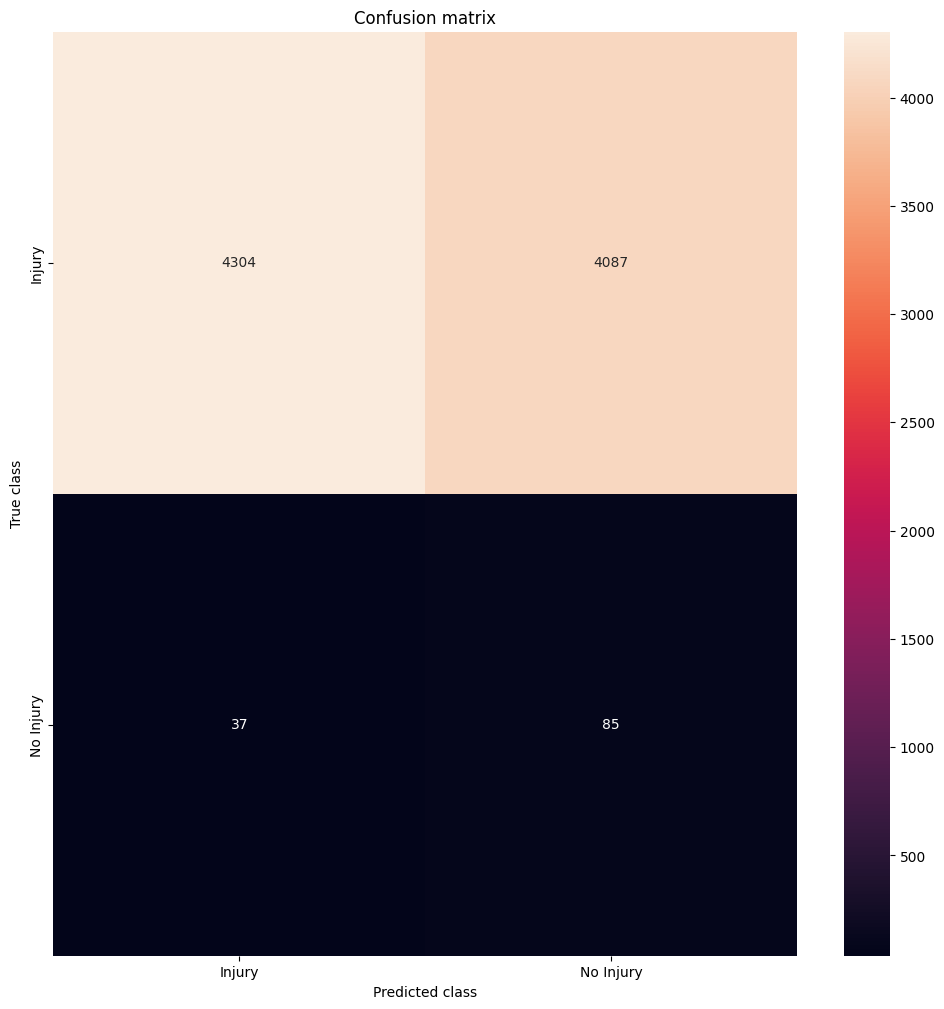

In [37]:
threshold = 0.0085 # we can equally choose to use different values for our threshold [0.009]
LABELS = ['Injury', 'No Injury']
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

The confusion matrix above helps us to understand our accuracy on the test data. 

We note that:
- 6963: The model predicts this case to be actually injury where the true case is injury too.
- 24: The model predicts no-injury with the true case being no injury.
- 96: The model predicts injury where the actual class in no-injury
- 1442: The model predicts no-injury where the actual class is injury.

The above explanation is given in the classification report below.

In [38]:
print(classification_report(error_df.true_class, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.51      0.68      8391
           1       0.02      0.70      0.04       122

    accuracy                           0.52      8513
   macro avg       0.51      0.60      0.36      8513
weighted avg       0.98      0.52      0.67      8513



In [39]:
f1_score(error_df.true_class, y_pred)

0.03959012575687005

In [40]:
accuracy_score(error_df.true_class, y_pred)

0.5155644308704335

In [41]:
mean_squared_error(error_df.true_class, y_pred)

0.48443556912956653

# Model 2: Isolation Forest

In [73]:
def drop_a_column(df, cols):
    """
    This functiion drops a column in a dataframe and returns the new df without
    the dropped column.

    cols is a list
    df is a dataframe
    """

    df_dr = df.drop(cols, axis = 1)

    return df_dr

In [74]:
# inliers = df_day[df_day.injury == 'no']
inliers = df_day[df_day.injury == 0]
inliers_y = inliers.injury
inliers = inliers.drop(['injury', 'athlete_id'], axis = 1)

In [75]:
# outliers = df_day[df_day.injury == 'yes']
outliers = df_day[df_day.injury == 1]
outliers_y = outliers.injury
outliers = outliers.drop(['injury', 'athlete_id'], axis = 1)

In [76]:
inliers.head(2)

,nr_sessions,total_km,km_z3-4,km_z5-t1-t2,km_sprinting,strength_training,hours_alternative,perceived_exertion,perceived_trainingsuccess,perceived_recovery,...,total_km_6,km_z3-4_6,km_z5-t1-t2_6,km_sprinting_6,strength_training_6,hours_alternative_6,perceived_exertion_6,perceived_trainingsuccess_6,perceived_recovery_6,date
0,1,5.8,0.0,0.6,1.2,0,0.0,0.11,0.00,0.18,...,0.0,0.0,0.0,0.0,0,1.0,0.1,0.0,0.15,0
1,0,0.0,0.0,0.0,0.0,0,0.0,-0.01,-0.01,-0.01,...,5.2,0.0,0.5,1.2,0,0.0,0.1,0.0,0.17,1


In [77]:
inliers.shape, outliers.shape # this is the respective dimension of our no-injury and injury data in our dataset respectively.

((42183, 71), (583, 71))

In [78]:
inliers_train, inliers_test = train_test_split(inliers, test_size=0.20, random_state=42)

## Train the isolation Forest Model

In [79]:
rng = np.random.RandomState(42)

In [80]:
# inliers = df_day[df_day.injury == 'no']
# inliers = df_day[df_day.injury == 1]
# inliers_y = inliers.injury
# inliers = inliers.drop(['injury'], axis = 1)

In [81]:
inliers_train, inliers_test = train_test_split(inliers, test_size=0.20, random_state = 42)

In [82]:
# inliers_tr_y = inliers_train.injury
# inliers_train = drop_a_column(inliers_train, ['injury', 'athlete_id'])

In [83]:
# inliers_test = drop_a_column(inliers_test, ['injury', 'athlete_id'])

In [84]:
model_iso = IsolationForest( max_samples=150, random_state=rng, contamination='auto')
# model_iso = IsolationForest( max_samples=150, random_state=rng, contamination=0.01)
model_iso.fit(inliers_train)
inlier_pred_test = model_iso.predict(inliers_test)
outlier_pred = model_iso.predict(outliers)

In [85]:
print("Accuracy in Detecting injury Cases:", list(inlier_pred_test).count(1)/inlier_pred_test.shape[0])
print("Accuracy in Detecting no-injury Cases:", list(outlier_pred).count(-1)/outlier_pred.shape[0])

Accuracy in Detecting injury Cases: 0.9615977243095887
Accuracy in Detecting no-injury Cases: 0.0823327615780446


In [86]:
np.unique(outlier_pred)

array([-1,  1])

In [87]:
# calculate score

# mark inliers 1, outliers -1

outliers_y = outliers_y.replace(1, -1)

outliers_y = outliers_y.replace(0, 1)

score = f1_score(outliers_y, outlier_pred, pos_label=-1)
print('F1 Score: %.3f' % score)

F1 Score: 0.152


In [88]:
accuracy_score(outliers_y, outlier_pred)

0.0823327615780446

In [89]:
mean_squared_error(outliers_y, outlier_pred)

3.6706689536878216

We can then compare the predictions from the model to the expected target values and calculate a score. Given that we have crisp class labels, we might use a score like precision, recall, or a combination of both, such as the F-measure (F1-score).

In this case, we will use F-measure score, which is the harmonic mean of precision and recall. We can calculate the F-measure using the f1_score() function and specify the label of the minority class as -1 via the “pos_label” argument.

# Model 3: One Class SVM

One Class Classification (OCC) aims to differentiate samples of one particular class by learning from single class samples during training. It is one of the most commonly used approaches to solve Anamoly Detection (AD), a subfield of machine learning that deals with identifying anomalous cases which the model has never seen before. OCC is also called unary classification, class-modelling.

In [118]:
X = df_day.drop(columns = ['injury', 'athlete_id'])
y = df_day['injury']

In [119]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.80, random_state=2, stratify=y)

<!-- train = trainX.copy()
train['injury'] = trainy
# train -->

<!-- # standardize the dataset
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(trainX)

# Apply transform to both the training set and the test set.
trainX = scaler.transform(trainX)
testX = scaler.transform(testX) -->


In [120]:
model_onec_svm = OneClassSVM() #one class svm model

In [121]:
# kernel = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
degree = np.arange(2,5)
gamma = ['scale', 'auto']
shrinking = [True, False]

tune_parameters = [{"kernel": kernel, 'degree':degree, 'gamma':gamma, 'shrinking':shrinking}]

In [122]:
tune_parameters

[{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
  'degree': array([2, 3, 4]),
  'gamma': ['scale', 'auto'],
  'shrinking': [True, False]}]

In [123]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model_onec_svm,
                           param_grid = tune_parameters,
                           cv = 10,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [124]:
# we fit on majority class
trainX_copy = trainX.copy()
trainX_copy['injury'] = trainy
trainX_copy = trainX_copy[trainX_copy.injury == 0]

trainy_copy = trainy[trainy ==0]
trainX_copy = trainX_copy.drop(columns = 'injury')
# trainy_copy = 

In [125]:
trainy_copy.shape, trainX_copy.shape

((8436,), (8436, 71))

In [126]:
# %%time
# grid_search.fit(trainX_copy, trainy_copy)  # hyper parameter tuning to avoid over fitting
# # grid_search.fit(trainX_copy)

In [127]:
# grid_search.best_score_, grid_search.best_estimator_

In [128]:
# oc_svm_best = grid_search.best_estimator_

In [129]:
# define outlier detection model
model = OneClassSVM(gamma='auto', nu=0.55)

In [130]:
# fit on majority class

model.fit(trainX_copy)

OneClassSVM(gamma='auto', nu=0.55)

In [131]:
# detect outliers in the test set
yhat = model.predict(testX)

In [132]:
# mark inliers 1, outliers -1

testy = testy.replace(1, -1)

testy = testy.replace(0, 1)

In [133]:
print(classification_report( testy, yhat ))

              precision    recall  f1-score   support

          -1       0.01      0.98      0.03       466
           1       1.00      0.09      0.17     33747

    accuracy                           0.10     34213
   macro avg       0.51      0.54      0.10     34213
weighted avg       0.98      0.10      0.16     34213



In [74]:
# calculate score
score = f1_score(testy, yhat, pos_label= -1)
print('F1 Score: %.3f' % score)

F1 Score: 0.029


In [75]:
accuracy_score(testy, yhat)

0.1029725542922281

In [76]:
mean_squared_error(testy, yhat)

3.5881097828310877

# A -  Repeating Models with Standardized data

In [90]:
df_day2 = df_day.drop(columns = 'athlete_id')

std_scaler = StandardScaler()

df_day_scaled = std_scaler.fit_transform(df_day2.drop(columns = 'injury').to_numpy())
df_day_scaled = pd.DataFrame(df_day_scaled, columns=list(df_day2.drop(columns = 'injury')))
df_day_scaled['injury'] = df_day.injury

## Model 2: Isolation Forest II

In [91]:
def drop_a_column(df, cols):
    """
    This functiion drops a column in a dataframe and returns the new df without
    the dropped column.

    cols is a list
    df is a dataframe
    """

    df_dr = df.drop(cols, axis = 1)

    return df_dr

In [92]:
# inliers = df_day_scaled[df_day_scaled.injury == 'no']
inliers = df_day_scaled[df_day_scaled.injury == 0] #  no injury data
inliers_y = inliers.injury #  no injury reponse data
inliers = inliers.drop(['injury'], axis = 1)

In [93]:
# outliers = df_day_scaled[df_day_scaled.injury == 'yes']
outliers = df_day_scaled[df_day_scaled.injury == 1] #  injury data
outliers_y = outliers.injury #  injury reponse data
outliers = outliers.drop(['injury'], axis = 1)

In [94]:
inliers.head(2)

,nr_sessions,total_km,km_z3-4,km_z5-t1-t2,km_sprinting,strength_training,hours_alternative,perceived_exertion,perceived_trainingsuccess,perceived_recovery,...,total_km_6,km_z3-4_6,km_z5-t1-t2_6,km_sprinting_6,strength_training_6,hours_alternative_6,perceived_exertion_6,perceived_trainingsuccess_6,perceived_recovery_6,date
0,0.293512,-0.165685,-0.298314,0.011076,2.331009,-0.356549,-0.297443,-0.535600,-0.949786,-0.083533,...,-0.943941,-0.29909,-0.319835,-0.150087,-0.356184,1.512013,-0.574761,-0.949638,-0.242559,-1.521713
1,-1.428581,-0.941799,-0.298314,-0.320065,-0.151023,-0.356549,-0.297443,-1.002056,-0.976938,-1.081857,...,-0.247831,-0.29909,-0.044280,2.330865,-0.356184,-0.292961,-0.574761,-0.949638,-0.137609,-1.520473


In [95]:
inliers.shape, outliers.shape # this is the respective dimension of our no-injury and injury data in our dataset respectively.

((42183, 71), (583, 71))

In [96]:
inliers_train, inliers_test = train_test_split(inliers, test_size=0.20, random_state=42)

### Train the isolation Forest Model

In [97]:
rng = np.random.RandomState(42)

In [98]:
inliers_train, inliers_test = train_test_split(inliers, test_size=0.20, random_state = 42)

In [99]:
model_iso = IsolationForest( max_samples=150, random_state=rng, contamination='auto')
# model_iso = IsolationForest( max_samples=150, random_state=rng, contamination=0.01)
model_iso.fit(inliers_train)
inlier_pred_test = model_iso.predict(inliers_test)
outlier_pred = model_iso.predict(outliers)

In [102]:
print("Accuracy in Detecting injury Cases:", list(inlier_pred_test).count(1)/inlier_pred_test.shape[0])
print("Accuracy in Detecting no-injury Cases:", list(outlier_pred).count(-1)/outlier_pred.shape[0])

Accuracy in Detecting injury Cases: 0.9615977243095887
Accuracy in Detecting no-injury Cases: 0.0823327615780446


In [101]:
np.unique(outlier_pred)

array([-1,  1])

In [89]:
# calculate score

# mark inliers 1, outliers -1

outliers_y = outliers_y.replace(1, -1)

outliers_y = outliers_y.replace(0, 1)

score = f1_score(outliers_y, outlier_pred, pos_label=-1)
print('F1 Score: %.3f' % score)

F1 Score: 0.152


In [90]:
accuracy_score(outliers_y, outlier_pred)

0.0823327615780446

In [91]:
mean_squared_error(outliers_y, outlier_pred)

3.6706689536878216

## Model 3: One Class SVM II

In [103]:
X = df_day_scaled.drop(columns = ['injury'])
y = df_day_scaled['injury']

In [104]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size = 0.80, random_state=2, stratify=y)

In [105]:
# we fit on majority class
trainX_copy = trainX.copy()
trainX_copy['injury'] = trainy
trainX_copy = trainX_copy[trainX_copy.injury == 0]

trainy_copy = trainy[trainy ==0]

trainX_copy = trainX_copy.drop(columns = 'injury')

In [106]:
trainy_copy.shape, trainX_copy.shape

((8436,), (8436, 71))

In [107]:
# define outlier detection model
model = OneClassSVM(gamma='auto', nu=.55)

In [108]:
# fit on majority class

model.fit(trainX_copy)

OneClassSVM(gamma='auto', nu=0.55)

In [109]:
# detect outliers in the test set
yhat = model.predict(testX)

In [110]:
# mark inliers 1, outliers -1

testy = testy.replace(1, -1)

testy = testy.replace(0, 1)

In [115]:
print(classification_report( testy, yhat ))

              precision    recall  f1-score   support

          -1       0.02      0.67      0.03       466
           1       0.99      0.46      0.63     33747

    accuracy                           0.46     34213
   macro avg       0.50      0.57      0.33     34213
weighted avg       0.98      0.46      0.62     34213



In [117]:
accuracy_score(testy, yhat)

0.4597667553269225

In [101]:
accuracy_score(testy, yhat)

0.4597667553269225

In [102]:
mean_squared_error(testy, yhat)

2.16093297869231

In [103]:
# calculate score
score = f1_score(testy, yhat, pos_label= -1)
print('F1 Score: %.3f' % score)

F1 Score: 0.033


The outcome for both scaled and unscaled data, the results are the same in terms of f1 score for IF, but for the SVM, there is an improvement with scaling.

# B - Repeating Models with PCA

## Model 2: Isolation Forest III

In [104]:
# Make an instance of the Model
pca_if = PCA(.95) # retain 95% variance in the data

In [105]:
# inliers = df_day_scaled[df_day_scaled.injury == 'no']
inliers = df_day_scaled[df_day_scaled.injury == 0] #  no injury data


####---------may comment-------------###
# inliers_y = inliers.injury #  no injury reponse data 
# inliers = inliers.drop(['injury'], axis = 1)

In [106]:
# outliers = df_day_scaled[df_day_scaled.injury == 'yes']
outliers = df_day_scaled[df_day_scaled.injury == 1] #  injury data
outliers_y = outliers.injury #  injury reponse data
outliers = outliers.drop(['injury'], axis = 1)

In [107]:
inliers.head(2)

,nr_sessions,total_km,km_z3-4,km_z5-t1-t2,km_sprinting,strength_training,hours_alternative,perceived_exertion,perceived_trainingsuccess,perceived_recovery,...,km_z3-4_6,km_z5-t1-t2_6,km_sprinting_6,strength_training_6,hours_alternative_6,perceived_exertion_6,perceived_trainingsuccess_6,perceived_recovery_6,date,injury
0,0.293512,-0.165685,-0.298314,0.011076,2.331009,-0.356549,-0.297443,-0.535600,-0.949786,-0.083533,...,-0.29909,-0.319835,-0.150087,-0.356184,1.512013,-0.574761,-0.949638,-0.242559,-1.521713,0
1,-1.428581,-0.941799,-0.298314,-0.320065,-0.151023,-0.356549,-0.297443,-1.002056,-0.976938,-1.081857,...,-0.29909,-0.044280,2.330865,-0.356184,-0.292961,-0.574761,-0.949638,-0.137609,-1.520473,0


In [108]:
inliers.shape, outliers.shape # this is the respective dimension of our no-injury and injury data in our dataset respectively.

((42183, 72), (583, 71))

In [109]:
inliers_train, inliers_test = train_test_split(inliers, test_size=0.20, random_state=42)

In [110]:
inliers_train_y = inliers_train.injury #  no injury reponse data
inliers_train = inliers_train.drop(['injury'], axis = 1)

inliers_test_y = inliers_test.injury
inliers_test = inliers_test.drop(['injury'], axis = 1)

In [111]:
# inliers_train

### Apply PCA on data splits

Fit PCA on training set on training set alone.

In [112]:
pca_if.fit(inliers_train)

PCA(n_components=0.95)

Apply the mapping (transform) to both the training set and the test set.

In [113]:
inliers_train.shape

(33746, 71)

In [114]:
inliers_train = pca_if.transform(inliers_train)
inliers_test = pca_if.transform(inliers_test)
outliers = pca_if.transform(outliers)

### Train the isolation Forest Model

In [115]:
rng = np.random.RandomState(42)

In [116]:
# inliers_train, inliers_test = train_test_split(inliers, test_size=0.20, random_state = 42)

In [117]:
model_iso = IsolationForest( max_samples=150, random_state=rng, contamination='auto')
# model_iso = IsolationForest( max_samples=150, random_state=rng, contamination=0.01)
model_iso.fit(inliers_train)
inlier_pred_test = model_iso.predict(inliers_test)
outlier_pred = model_iso.predict(outliers)

In [118]:
print("Accuracy in Detecting injury Cases:", list(inlier_pred_test).count(1)/inlier_pred_test.shape[0])
print("Accuracy in Detecting no-injury Cases:", list(outlier_pred).count(-1)/outlier_pred.shape[0])

Accuracy in Detecting injury Cases: 0.9502192722531706
Accuracy in Detecting no-injury Cases: 0.0548885077186964


In [119]:
np.unique(outlier_pred)

array([-1,  1])

In [120]:
# calculate score

# mark inliers 1, outliers -1

outliers_y = outliers_y.replace(1, -1)

outliers_y = outliers_y.replace(0, 1)

score = f1_score(outliers_y, outlier_pred, pos_label=-1)
print('F1 Score: %.3f' % score)

F1 Score: 0.104


In [121]:
accuracy_score(outliers_y, outlier_pred)

0.0548885077186964

In [122]:
mean_squared_error(outliers_y, outlier_pred)

3.7804459691252146

The use of PCA reduced our prediction accuracy

## Model 3: One Class SVM III

In [134]:
X = df_day_scaled.drop(columns = ['injury'])
y = df_day_scaled['injury']

In [135]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.80, random_state=2, stratify=y)

In [136]:
# we fit on majority class
trainX_copy = trainX.copy()
trainX_copy['injury'] = trainy
trainX_copy = trainX_copy[trainX_copy.injury == 0]

trainy_copy = trainy[trainy ==0]
trainX_copy = trainX_copy.drop(columns = 'injury')
# trainy_copy = 

### Apply PCA on data splits

In [137]:
# Make an instance of the Model
pca_oc_svm = PCA(.95) # retain 95% variance in the data

Fit PCA on training set on training set alone.

In [138]:
pca_oc_svm.fit(trainX_copy)

PCA(n_components=0.95)

Apply the mapping (transform) to both the training set and the test set.

In [139]:
trainX_copy = pca_oc_svm.transform(trainX_copy)
testX = pca_oc_svm.transform(testX)
# outliers = pca_oc_svm.transform(outliers)

In [140]:
# trainy_copy.shape, trainX_copy.shape

In [141]:
# define outlier detection model
model_one_class_svm_pca = OneClassSVM(gamma='auto', nu=0.55)

In [142]:
# fit on majority class

model_one_class_svm_pca.fit(trainX_copy)

OneClassSVM(gamma='auto', nu=0.55)

In [143]:
# detect outliers in the test set
yhat = model_one_class_svm_pca.predict(testX)

In [144]:
# mark inliers 1, outliers -1

testy = testy.replace(1, -1)

testy = testy.replace(0, 1)

In [145]:
# calculate score
score = f1_score(testy, yhat, pos_label= -1)
print('F1 Score: %.3f' % score)

F1 Score: 0.034


In [146]:
print(classification_report( testy, yhat ))

              precision    recall  f1-score   support

          -1       0.02      0.69      0.03       466
           1       0.99      0.46      0.63     33747

    accuracy                           0.46     34213
   macro avg       0.50      0.57      0.33     34213
weighted avg       0.98      0.46      0.62     34213



In [147]:
accuracy_score(testy, yhat)

0.4642095110045889

In [148]:
mean_squared_error(testy, yhat)

2.1431619559816446

The accuracy further decreased  by 0.002 when we use PCA in One Class SVM.

# C - Dim Red + Unscaled Data

## Model 3: Isolation Forest IV

In [149]:
# Make an instance of the Model
pca_if = PCA(.95) # retain 95% variance in the data

In [150]:
# inliers = df_day_scaled[df_day_scaled.injury == 'no']
inliers = df_day[df_day.injury == 0] #  no injury data


####---------may comment-------------###
# inliers_y = inliers.injury #  no injury reponse data 
# inliers = inliers.drop(['injury'], axis = 1)

In [151]:
# outliers = df_day_scaled[df_day_scaled.injury == 'yes']
outliers = df_day[df_day.injury == 1] #  injury data
outliers_y = outliers.injury #  injury reponse data
outliers = outliers.drop(['injury'], axis = 1)

In [152]:
inliers.head(2)

,nr_sessions,total_km,km_z3-4,km_z5-t1-t2,km_sprinting,strength_training,hours_alternative,perceived_exertion,perceived_trainingsuccess,perceived_recovery,...,km_z5-t1-t2_6,km_sprinting_6,strength_training_6,hours_alternative_6,perceived_exertion_6,perceived_trainingsuccess_6,perceived_recovery_6,athlete_id,injury,date
0,1,5.8,0.0,0.6,1.2,0,0.0,0.11,0.00,0.18,...,0.0,0.0,0,1.0,0.1,0.0,0.15,0,0,0
1,0,0.0,0.0,0.0,0.0,0,0.0,-0.01,-0.01,-0.01,...,0.5,1.2,0,0.0,0.1,0.0,0.17,0,0,1


In [153]:
inliers.shape, outliers.shape # this is the respective dimension of our no-injury and injury data in our dataset respectively.

((42183, 73), (583, 72))

In [154]:
inliers_train, inliers_test = train_test_split(inliers, test_size=0.20, random_state=42)

In [155]:
inliers_train_y = inliers_train.injury #  no injury reponse data
inliers_train = inliers_train.drop(['injury'], axis = 1)

inliers_test_y = inliers_test.injury
inliers_test = inliers_test.drop(['injury'], axis = 1)

In [156]:
# inliers_train

### Apply PCA on data splits

Fit PCA on training set on training set alone.

In [157]:
pca_if.fit(inliers_train)

PCA(n_components=0.95)

Apply the mapping (transform) to both the training set and the test set.

In [158]:
inliers_train = pca_if.transform(inliers_train)
inliers_test = pca_if.transform(inliers_test)
outliers = pca_if.transform(outliers)

### Train the isolation Forest Model

In [159]:
rng = np.random.RandomState(42)

In [160]:
# inliers_train, inliers_test = train_test_split(inliers, test_size=0.20, random_state = 42)

In [161]:
model_iso = IsolationForest( max_samples=150, random_state=rng, contamination='auto')
# model_iso = IsolationForest( max_samples=150, random_state=rng, contamination=0.01)
model_iso.fit(inliers_train)
inlier_pred_test = model_iso.predict(inliers_test)
outlier_pred = model_iso.predict(outliers)

In [162]:
print("Accuracy in Detecting injury Cases:", list(inlier_pred_test).count(1)/inlier_pred_test.shape[0])
print("Accuracy in Detecting no-injury Cases:", list(outlier_pred).count(-1)/outlier_pred.shape[0])

Accuracy in Detecting injury Cases: 0.2561336968116629
Accuracy in Detecting no-injury Cases: 0.8198970840480274


In [151]:
np.unique(outlier_pred)

array([-1,  1])

In [163]:
# calculate score

# mark inliers 1, outliers -1

outliers_y = outliers_y.replace(1, -1)

outliers_y = outliers_y.replace(0, 1)

score = f1_score(outliers_y, outlier_pred, pos_label=-1)
print('F1 Score: %.3f' % score)

F1 Score: 0.901


In [164]:
accuracy_score(outliers_y, outlier_pred)

0.8198970840480274

In [165]:
mean_squared_error(outliers_y, outlier_pred)

0.7204116638078902

The use of PCA reduced our prediction accuracy

## Model 3: One Class SVM IV

In [166]:
X = df_day.drop(columns = ['injury'])
y = df_day['injury']

In [167]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.80, random_state=2, stratify=y)

In [168]:
# we fit on majority class
trainX_copy = trainX.copy()
trainX_copy['injury'] = trainy
trainX_copy = trainX_copy[trainX_copy.injury == 0]

trainy_copy = trainy[trainy ==0]
trainX_copy = trainX_copy.drop(columns = 'injury')
# trainy_copy = 

### Apply PCA on data splits

In [169]:
# Make an instance of the Model
pca_oc_svm = PCA(.95) # retain 95% variance in the data

Fit PCA on training set on training set alone.

In [170]:
pca_oc_svm.fit(trainX_copy)

PCA(n_components=0.95)

Apply the mapping (transform) to both the training set and the test set.

In [171]:
trainX_copy = pca_oc_svm.transform(trainX_copy)
testX = pca_oc_svm.transform(testX)
# outliers = pca_oc_svm.transform(outliers)

In [172]:
# trainy_copy.shape, trainX_copy.shape

In [173]:
# define outlier detection model
model_one_class_svm_pca = OneClassSVM(gamma='auto', nu=0.55)

In [174]:
# fit on majority class

model_one_class_svm_pca.fit(trainX_copy)

OneClassSVM(gamma='auto', nu=0.55)

In [175]:
# detect outliers in the test set
yhat = model_one_class_svm_pca.predict(testX)

In [176]:
# mark inliers 1, outliers -1

testy = testy.replace(1, -1)

testy = testy.replace(0, 1)

In [177]:
print(classification_report( testy, yhat ))

              precision    recall  f1-score   support

          -1       0.02      0.82      0.03       466
           1       0.99      0.29      0.45     33747

    accuracy                           0.30     34213
   macro avg       0.50      0.56      0.24     34213
weighted avg       0.98      0.30      0.44     34213



In [178]:
# calculate score
score = f1_score(testy, yhat, pos_label= -1)
print('F1 Score: %.3f' % score)

F1 Score: 0.031


In [179]:
accuracy_score(testy, yhat)

0.29748925846900304

In [180]:
mean_squared_error(testy, yhat)

2.810042966123988

The accuracy further decreased  by 0.002 when we use PCA in One Class SVM.

# Auto Encoder II

## Starting and initializing H2O server.

In [12]:
h2o.init() # initializing h2o server
# h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.331-b09, mixed mode)
  Starting server from C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\USER\AppData\Local\Temp\tmpztj_agx9
  JVM stdout: C:\Users\USER\AppData\Local\Temp\tmpztj_agx9\h2o_USER_started_from_python.out
  JVM stderr: C:\Users\USER\AppData\Local\Temp\tmpztj_agx9\h2o_USER_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.4
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_USER_61dy3j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.759 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [13]:
hdf_day = h2o.import_file(r"data/day_approach_maskedID_timeseries_v3.0.csv") #import the file as a h2o file
hdf_day["date"] = hdf_day["date"].asfactor() # coonvert date to factor i.e categorical
hdf_day["injury"] = hdf_day["injury"].asfactor()
features_day  = hdf_day.drop(['athlete_id', 'C1'], axis=1) # we do not need the athlete id again alonside the 'C1' column which is an automatic addition by h2o import
train_day , test_day = features_day.split_frame([0.8]) # 80% of data for training and 20% for testing 

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


We used a 80-20 split between the training and testing because of the imbalance in the dataset. This spit enables us to get enough of the undersampled class.

In [14]:
features_day.head(3)

nr_sessions,total_km,km_z3-4,km_z5-t1-t2,km_sprinting,strength_training,hours_alternative,perceived_exertion,perceived_trainingsuccess,perceived_recovery,nr_sessions_1,total_km_1,km_z3-4_1,km_z5-t1-t2_1,km_sprinting_1,strength_training_1,hours_alternative_1,perceived_exertion_1,perceived_trainingsuccess_1,perceived_recovery_1,nr_sessions_2,total_km_2,km_z3-4_2,km_z5-t1-t2_2,km_sprinting_2,strength_training_2,hours_alternative_2,perceived_exertion_2,perceived_trainingsuccess_2,perceived_recovery_2,nr_sessions_3,total_km_3,km_z3-4_3,km_z5-t1-t2_3,km_sprinting_3,strength_training_3,hours_alternative_3,perceived_exertion_3,perceived_trainingsuccess_3,perceived_recovery_3,nr_sessions_4,total_km_4,km_z3-4_4,km_z5-t1-t2_4,km_sprinting_4,strength_training_4,hours_alternative_4,perceived_exertion_4,perceived_trainingsuccess_4,perceived_recovery_4,nr_sessions_5,total_km_5,km_z3-4_5,km_z5-t1-t2_5,km_sprinting_5,strength_training_5,hours_alternative_5,perceived_exertion_5,perceived_trainingsuccess_5,perceived_recovery_5,nr_sessions_6,total_km_6,km_z3-4_6,km_z5-t1-t2_6,km_sprinting_6,strength_training_6,hours_alternative_6,perceived_exertion_6,perceived_trainingsuccess_6,perceived_recovery_6,injury,date
1,5.8,0,0.6,1.2,0,0,0.11,0,0.18,0,0,0,0,0,0,0,-0.01,-0.01,-0.01,1,0,0,0,0,1,0,0.1,0,0.17,0,0,0,0,0,0,0,-0.01,-0.01,-0.01,1,0,0,0,0,0,1.08,0.08,0,0.18,1,16.4,10,0,0,1,0,0.11,0,0.17,1,0,0,0,0,0,1,0.1,0,0.15,0,0
0,0,0,0,0,0,0,-0.01,-0.01,-0.01,1,0,0,0,0,1,0,0.1,0,0.17,0,0,0,0,0,0,0,-0.01,-0.01,-0.01,1,0,0,0,0,0,1.08,0.08,0,0.18,1,16.4,10,0,0,1,0,0.11,0,0.17,1,0,0,0,0,0,1,0.1,0,0.15,1,5.2,0,0.5,1.2,0,0,0.1,0,0.17,0,1
1,0,0,0,0,1,0,0.1,0,0.17,0,0,0,0,0,0,0,-0.01,-0.01,-0.01,1,0,0,0,0,0,1.08,0.08,0,0.18,1,16.4,10,0,0,1,0,0.11,0,0.17,1,0,0,0,0,0,1,0.1,0,0.15,1,5.2,0,0.5,1.2,0,0,0.1,0,0.17,0,0,0,0,0,0,0,-0.01,-0.01,-0.01,0,2


In [15]:
features_day.types

{'nr_sessions': 'int',
 'total_km': 'real',
 'km_z3-4': 'real',
 'km_z5-t1-t2': 'real',
 'km_sprinting': 'real',
 'strength_training': 'int',
 'hours_alternative': 'real',
 'perceived_exertion': 'real',
 'perceived_trainingsuccess': 'real',
 'perceived_recovery': 'real',
 'nr_sessions_1': 'int',
 'total_km_1': 'real',
 'km_z3-4_1': 'real',
 'km_z5-t1-t2_1': 'real',
 'km_sprinting_1': 'real',
 'strength_training_1': 'int',
 'hours_alternative_1': 'real',
 'perceived_exertion_1': 'real',
 'perceived_trainingsuccess_1': 'real',
 'perceived_recovery_1': 'real',
 'nr_sessions_2': 'int',
 'total_km_2': 'real',
 'km_z3-4_2': 'real',
 'km_z5-t1-t2_2': 'real',
 'km_sprinting_2': 'real',
 'strength_training_2': 'int',
 'hours_alternative_2': 'real',
 'perceived_exertion_2': 'real',
 'perceived_trainingsuccess_2': 'real',
 'perceived_recovery_2': 'real',
 'nr_sessions_3': 'int',
 'total_km_3': 'real',
 'km_z3-4_3': 'real',
 'km_z5-t1-t2_3': 'real',
 'km_sprinting_3': 'real',
 'strength_training_3

We now preprocess the dataset by seperating training and test data.

In [16]:
# converting to pandas dataframe
train_day_df = train_day.as_data_frame()
test_day_df = test_day.as_data_frame()

# noinjury_df_tr = train_day_df[train_day_df['injury'] == 0]
# injury_df_tr = train_day_df[train_day_df['injury'] == 1]

In [17]:
# drop the Class variable

Y_test_df = test_day_df['injury'] # true labels of the testing set
Y_test_df_ = pd.DataFrame(Y_test_df) # convert to pandas dataframe from pandas series
test_df = test_day_df.drop(['injury'], axis=1)

In [18]:
# converting to h2o frame
Y_test_h2o = h2o.H2OFrame(Y_test_df_) 
train_h2o = h2o.H2OFrame(train_day_df) 
test_h2o = h2o.H2OFrame(test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [19]:
cols = train_h2o.columns
cols.remove('injury')

In [20]:
cols

['nr_sessions',
 'total_km',
 'km_z3-4',
 'km_z5-t1-t2',
 'km_sprinting',
 'strength_training',
 'hours_alternative',
 'perceived_exertion',
 'perceived_trainingsuccess',
 'perceived_recovery',
 'nr_sessions_1',
 'total_km_1',
 'km_z3-4_1',
 'km_z5-t1-t2_1',
 'km_sprinting_1',
 'strength_training_1',
 'hours_alternative_1',
 'perceived_exertion_1',
 'perceived_trainingsuccess_1',
 'perceived_recovery_1',
 'nr_sessions_2',
 'total_km_2',
 'km_z3-4_2',
 'km_z5-t1-t2_2',
 'km_sprinting_2',
 'strength_training_2',
 'hours_alternative_2',
 'perceived_exertion_2',
 'perceived_trainingsuccess_2',
 'perceived_recovery_2',
 'nr_sessions_3',
 'total_km_3',
 'km_z3-4_3',
 'km_z5-t1-t2_3',
 'km_sprinting_3',
 'strength_training_3',
 'hours_alternative_3',
 'perceived_exertion_3',
 'perceived_trainingsuccess_3',
 'perceived_recovery_3',
 'nr_sessions_4',
 'total_km_4',
 'km_z3-4_4',
 'km_z5-t1-t2_4',
 'km_sprinting_4',
 'strength_training_4',
 'hours_alternative_4',
 'perceived_exertion_4',
 'perce

We now create a local estimator and start the training process

In the deep learning model below, we included the h2o library for anomaly detection i.e autoencoder.

In [21]:
# our model with its hyper parameters

deepl_model = H2ODeepLearningEstimator(activation = "Tanh",
                               hidden = [15,7,7,7,15],
                               epochs = 100,
                               standardize = True,
                                stopping_metric = 'MSE',
                                loss = 'automatic',
                                train_samples_per_iteration = 32,
                                shuffle_training_data = True,     
                               autoencoder = True,
                               l1 = 10e-5)

In [22]:
%timeit deepl_model.train(x = cols , y = 'injury', training_frame = train_h2o) # this takes a while at least an hour 

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
2min 54s ± 22.5 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
# Evaluate performance:

perf = deepl_model.model_performance()
perf


ModelMetricsAutoEncoder: deeplearning
** Reported on train data. **

MSE: 0.009040212272487153
RMSE: 0.09508003088181637


The MSE & RMSE helps us to understand how far off our prediction is on the training data as opposed to the actual results. The small number above which almost equals zero tells us that our model performs well on the training set.

We also note that $RMSE = \sqrt{MSE}$

Show the model feature importance in a dataframe

In [24]:
deepl_model._model_json['output']['variable_importances'].as_data_frame()

,variable,relative_importance,scaled_importance,percentage
0,perceived_trainingsuccess_5,1.000000,1.000000,0.064083
1,nr_sessions_1,0.938523,0.938523,0.060144
2,nr_sessions_4,0.892227,0.892227,0.057177
3,nr_sessions_2,0.845211,0.845211,0.054164
4,perceived_trainingsuccess_1,0.785141,0.785141,0.050314
...,...,...,...,...
67,km_sprinting_4,0.003929,0.003929,0.000252
68,km_sprinting_5,0.003539,0.003539,0.000227
69,km_sprinting_3,0.003476,0.003476,0.000223
70,km_sprinting,0.002362,0.002362,0.000151


Visualization of the feature importance

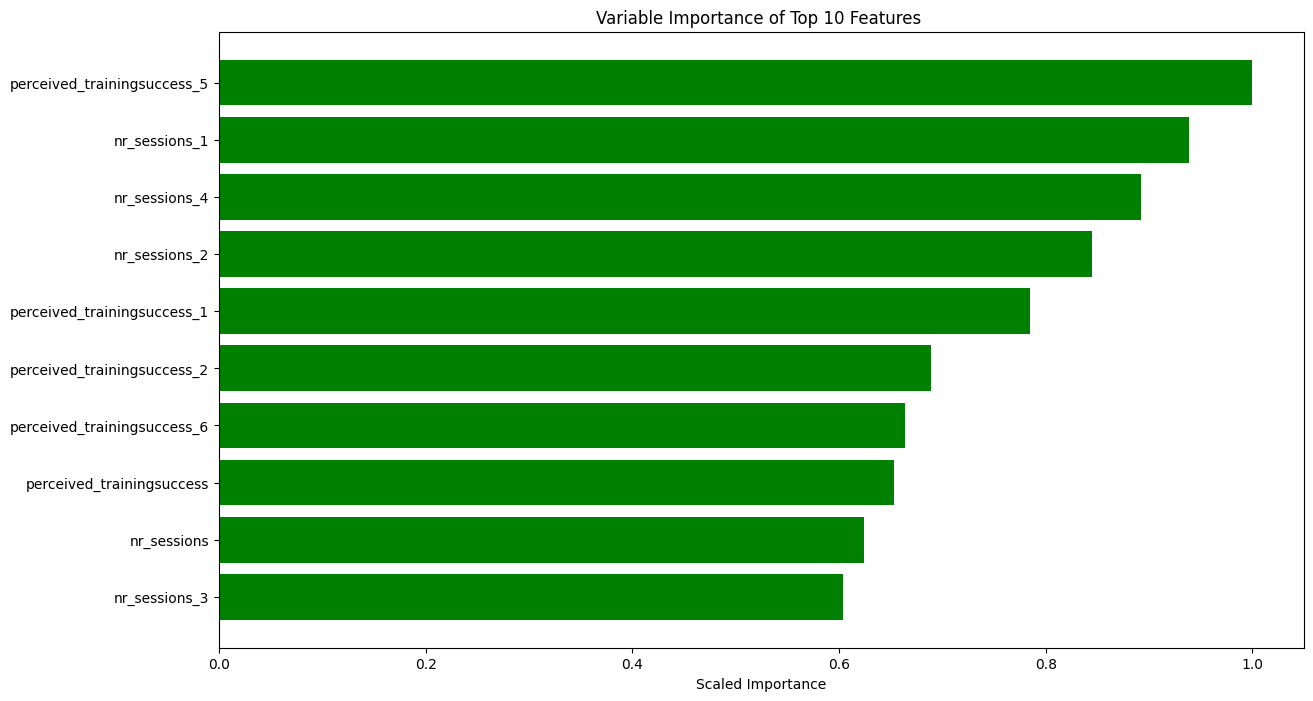

In [25]:
# plotting the variable importance
rcParams['figure.figsize'] = 14, 8
#plt.rcdefaults()
fig, ax = plt.subplots()

variables = deepl_model._model_json['output']['variable_importances']['variable']
var = variables[0:10]
y_pos = np.arange(len(var))

scaled_importance = deepl_model._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance[0:10]

ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
# ax.set_yticklabels(variables)
ax.set_yticklabels(var)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance of Top 10 Features ')
plt.show()

Visualize the model loss.

Text(0.5, 0, 'epoch')

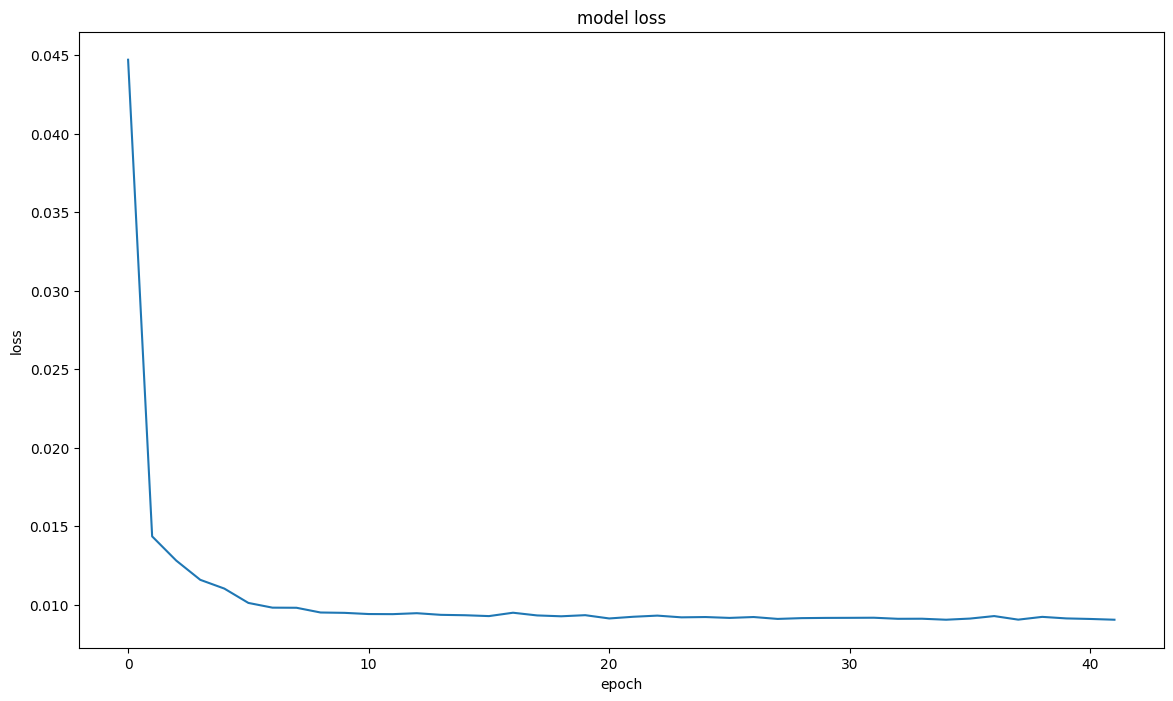

In [26]:
# plotting the loss

scoring_history = deepl_model.score_history()

rcParams['figure.figsize'] = 14, 8
plt.plot(scoring_history['training_mse'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

Visualize the scatter plot across the dataset

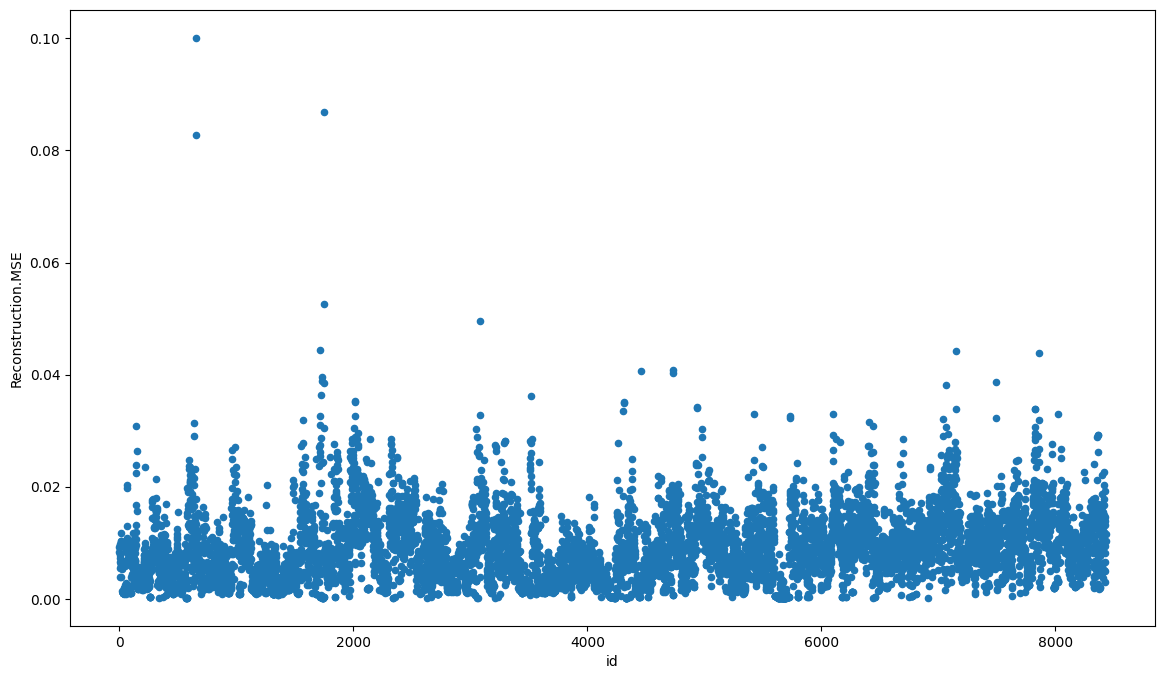

In [27]:
test_rec_error = deepl_model.anomaly(test_h2o) 

# deepl is a H2O function which calculates the error for the dataset

# converting to pandas dataframe
test_rec_error_df = test_rec_error.as_data_frame()

# plotting the testing dataset against the error
test_rec_error_df['id'] = test_rec_error_df.index
rcParams['figure.figsize'] = 14, 8
test_rec_error_df.plot(kind="scatter", x='id', y="Reconstruction.MSE")
plt.show()

In [28]:
# predicting the class for the testing dataset
predictions = deepl_model.predict(test_h2o)
error_df = pd.DataFrame({'reconstruction_error': test_rec_error_df['Reconstruction.MSE'],
                        'true_class': Y_test_df})
error_df.groupby('true_class').count()

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


,reconstruction_error
true_class,
0,8324
1,108


Calculate the threshold score/ cutoff score

In [29]:
score_mean = error_df['reconstruction_error'].mean()
score_std = error_df['reconstruction_error'].std()
score_cutoff = score_mean + 4*score_std
score_cutoff

0.03373700384182257

In [30]:
error_df[(error_df['true_class'] == 1) & error_df['reconstruction_error'] > 0.0095].count()

reconstruction_error    108
true_class              108
dtype: int64

Print out the confusion matrix and adjust and tune the confusion matrix from the threshold.

In [31]:
# len(y_pred), len(error_df.true_class)

In [32]:
error_df[error_df['true_class'] == 'NaN' ]

,reconstruction_error,true_class


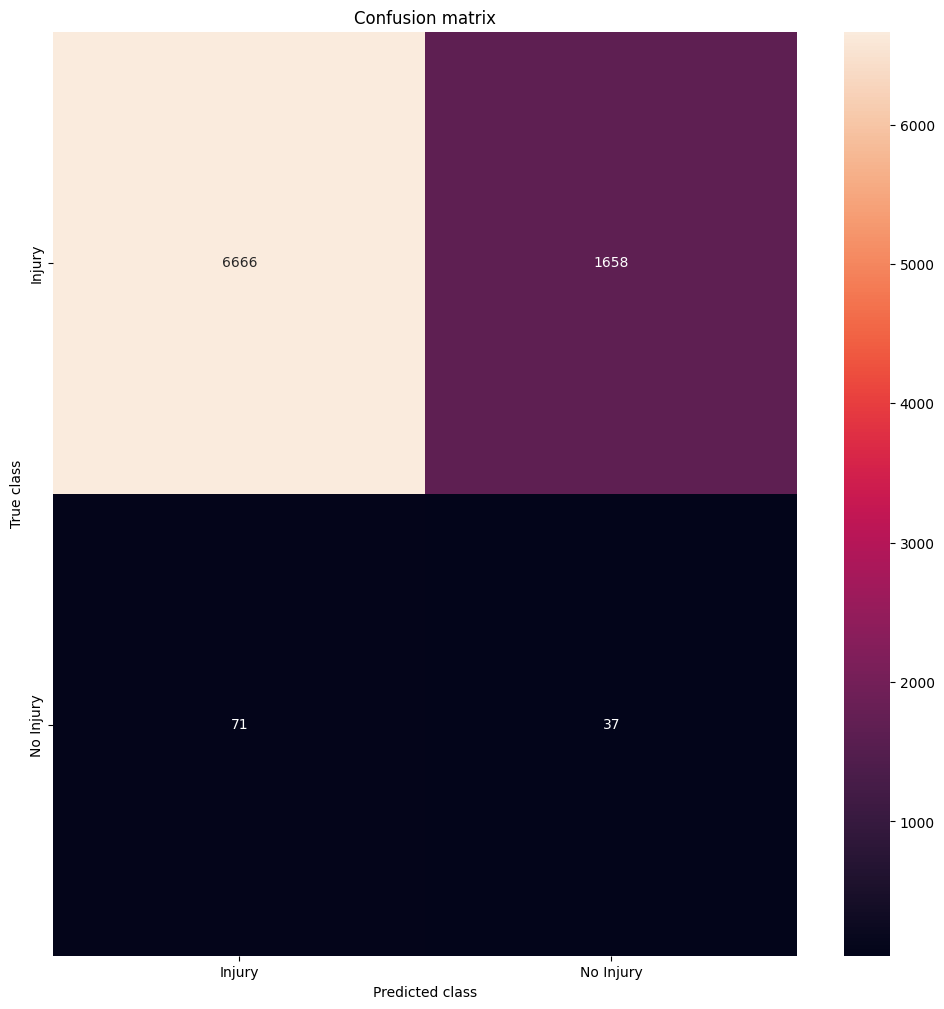

In [61]:
threshold = 0.0135 # we can equally choose to use different values for our threshold [0.009]
LABELS = ['Injury', 'No Injury']
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

The confusion matrix above helps us to understand our accuracy on the test data. 

We note that:
- 6963: The model predicts this case to be actually injury where the true case is injury too.
- 24: The model predicts no-injury with the true case being no injury.
- 96: The model predicts injury where the actual class in no-injury
- 1442: The model predicts no-injury where the actual class is injury.

The above explanation is given in the classification report below.

In [62]:
print( classification_report(error_df.true_class, y_pred) )

              precision    recall  f1-score   support

           0       0.99      0.80      0.89      8324
           1       0.02      0.34      0.04       108

    accuracy                           0.79      8432
   macro avg       0.51      0.57      0.46      8432
weighted avg       0.98      0.79      0.87      8432



In [63]:
f1_score( error_df.true_class, y_pred )

0.041042706600110924

In [64]:
accuracy_score(error_df.true_class, y_pred)

0.7949478178368121

In [65]:
mean_squared_error(error_df.true_class, y_pred)

0.20505218216318785

# Conclusion I

- All models i.e Autoenconders, Isolation Forest and One Class SVM have a high accuracy.  
- Isolation Forest has the best f1 score and we conclude it to be our best model.